In [1]:
#1
from fastai.conv_learner import *
from matplotlib import patches, patheffects
from collections import defaultdict

In [2]:
#2
coco_path = Path('/scratch/arka/Ark_git_files/coco/')
ann_path = coco_path / 'annotations'
train_path = coco_path / 'train2017'
val_path = coco_path / 'val2017'

In [3]:
instances_train2017 = json.load((ann_path / 'instances_train2017.json').open('r'))
instances_val2017 = json.load((ann_path / 'instances_val2017.json').open('r'))

In [4]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']

In [5]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

In [6]:
JPEGS = 'imgs'

In [ ]:
# cats = json.load(open('category.json', 'r'))
# trn_fns = json.load(open('trn_fns.json', 'r'))
# trn_ids = json.load(open('trn_ids.json', 'r'))
# trn_ids = [str(o) for o in trn_ids]
# trn_anno = json.load(open('trn_anno.json', 'r'))

In [7]:
cats = dict((o[ID], o['name']) for o in instances_train2017[CATEGORIES])
trn_fns = dict((o[ID], o[FILE_NAME]) for o in instances_train2017[IMAGES])
trn_ids = [o[ID] for o in instances_train2017[IMAGES]]


In [8]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [9]:
for key,value in cats.items():
    if (' ' in value):       
        cats[key]=value.replace(' ','_')
#         print(key, value)

In [10]:
trn_anno = collections.defaultdict(list)
for o in instances_train2017[ANNOTATIONS]:
    bb = o[BBOX]
    bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
    trn_anno[o[IMG_ID]].append((bb.tolist(),o[CAT_ID]))
        
len(trn_anno)

117266

In [ ]:
cdict = defaultdict(list)
for o in trn_ids:
    ann = trn_anno[o]
    for a in ann:
        cdict[o].append(a[1])

In [ ]:
cdict[o]

In [ ]:
dfm = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [' '.join([cats[p] for p in cdict[o]]) for o in trn_ids]}, columns=['fn','cat'])
csvs = coco_path / 'csv_new' / 'train_cls.csv'
csvs.parent.mkdir(exist_ok=True, parents=True)
dfm.to_csv(csvs, index=False)

In [ ]:
np.round(a[0]).astype(int)

In [ ]:
bdict = defaultdict(list)
for o in trn_ids:
    ann = trn_anno[o]
    for a in ann:
        bdict[o].append(str(np.round(a[0]).astype(int).tolist()).strip('[').strip(']').replace(',',''))

In [ ]:
bdict[o][0]

In [ ]:
' '.join(bdict[o])

In [ ]:
json.dump(cats, open('category.json', 'w'))
json.dump(trn_fns, open('trn_fns.json', 'w'))
json.dump(trn_ids, open('trn_ids.json', 'w'))
# json.dump(trn_anno, open('trn_anno.json', 'w'))

In [ ]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 
                   'bbox': [' '.join(bdict[o]) for o in trn_ids]}, columns=['fn','bbox'])
csvs = coco_path / 'csv_new' / 'train_bbx.csv'
csvs.parent.mkdir(exist_ok=True, parents=True)
df.to_csv(csvs, index=False)

In [ ]:
df.head()

In [ ]:
df['bbox'][1].split(' ')

In [11]:
MBB_CSV = coco_path / 'csv_new' / 'train_bbx.csv'
JPEGS = 'imgs'
sz=224
bs=32
f_model = resnet34
aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(coco_path, JPEGS, MBB_CSV, tfms=tfms, bs=bs, continuous=True, num_workers=4)

In [12]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

In [13]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [14]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))


In [15]:
mc = [[cats[p[1]] for p in trn_anno[o]] for o in trn_ids]
id2cat = list(cats.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc]); mcs

array([array([3, 0, 0, 1]), array([ 0, 43, 55, 71]),
       array([19, 19, 19, 19, 19, 25, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 19, 19, 19,  0]),
       ...,
       array([56, 56,  0, 28, 39, 39, 39, 39, 39, 39, 39, 39, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 60,
       73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 39, 39, 39, 39, 40, 40]),
       array([39, 39,  0,  0,  0, 40, 40, 40,  0,  0, 39,  0, 41]),
       array([ 0,  0,  0,  0,  0, 40, 40, 40, 40, 41, 71,  0, 72])], dtype=object)

In [16]:
val_idxs = get_cv_idxs(len(trn_fns))
((val_mcs,trn_mcs),) = split_by_idx(val_idxs, mcs)

In [17]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_mcs)
val_ds2 = ConcatLblDataset(md.val_ds, val_mcs)
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [18]:
x,y=to_np(next(iter(md.val_dl)))
x=md.val_ds.ds.denorm(x)


In [19]:
y[0][0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,  91., 127., 222., 164.,  14., 120., 199., 172., 108., 166., 135.,
       177., 114., 171., 134., 180.], dtype=float32)

In [20]:
y[0].shape

(32, 124)

In [21]:
y[1]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  3,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 64, 64, 66,
        66, 64, 62, 62, 62, 64],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  0, 15],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, 71, 71],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, 61, 71],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0, 71, 61, 39],
       [ 0,  

In [22]:
y[1].shape

(32, 31)

In [23]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


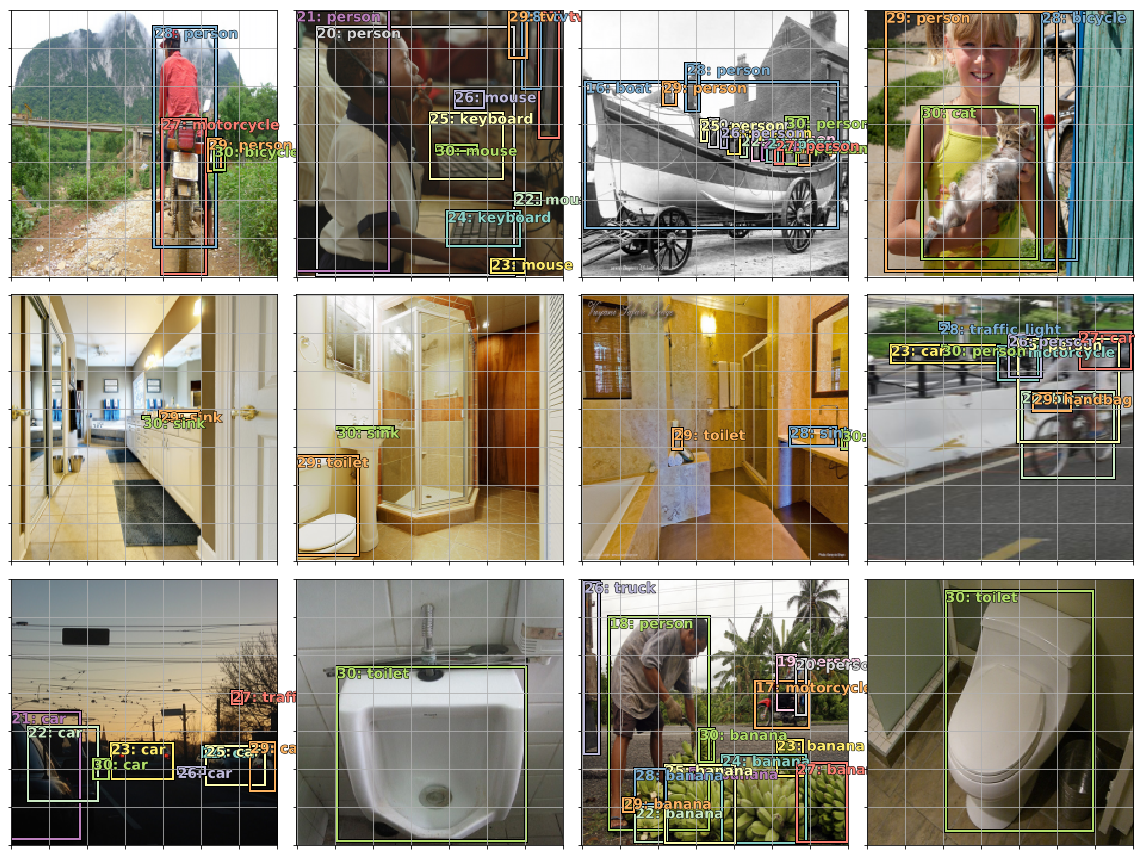

In [24]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

In [26]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [35]:
k = 1
anc_grids = [28,14,7,4,2] #Depends of the initial size 224.
# anc_zooms = [1., 2**(1/3), 2**(2/3)]
anc_zooms = [1]
# anc_ratios = [(1.,1.), (1.,2), (2,1.)]
anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
anc_offsets = [1/(o*2) for o in anc_grids]
anc_x = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])


In [36]:
anchors.size()

torch.Size([1049, 4])

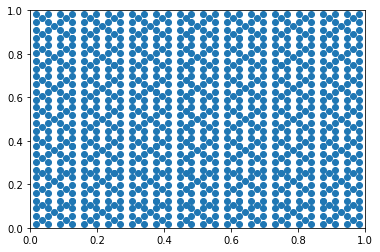

In [37]:
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [38]:
n_clas = len(id2cat)+1
n_act = k*(4+n_clas)

## Creating the Model

### Backbone

In [39]:
res50 = resnet50(pretrained=True)

In [40]:
def pad_out(k):
    return (k-1)//2

In [41]:
class FPN_backbone(nn.Module):
    def __init__(self, inch_list):
        super().__init__()
        
#         self.backbone = backbone
        
        # expects c3, c4, c5 channel dims
        self.inch_list = inch_list
        self.feat_size = 256
        self.p7_gen = nn.Conv2d(in_channels=self.feat_size, out_channels=self.feat_size, stride=2, kernel_size=3,
                               padding=1)
        self.p6_gen = nn.Conv2d(in_channels=self.inch_list[2], 
                            out_channels=self.feat_size, kernel_size=3, stride=2, padding=pad_out(3))
        self.p5_gen1 = nn.Conv2d(in_channels=self.inch_list[2], 
                                 out_channels=self.feat_size, kernel_size=1, padding=pad_out(1))
#         self.p5_gen2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.p5_gen3 = nn.Conv2d(in_channels=self.feat_size, out_channels=self.feat_size,
                                kernel_size=3, padding=pad_out(3))
        
        self.p4_gen1 = nn.Conv2d(in_channels=self.inch_list[1], out_channels=self.feat_size, kernel_size=1,
                                padding=pad_out(1))
#         self.p4_gen2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.p4_gen3 = nn.Conv2d(in_channels=self.feat_size, out_channels=self.feat_size, kernel_size=3, 
                                padding=pad_out(3))
        
        self.p3_gen1 = nn.Conv2d(in_channels=self.inch_list[0], out_channels=self.feat_size, kernel_size=1,
                                padding=pad_out(1))
        self.p3_gen2 = nn.Conv2d(in_channels=self.feat_size, out_channels=self.feat_size, kernel_size=3,
                                padding=pad_out(3))
        
    def forward(self, inp):
        # expects inp to be output of c3, c4, c5
        c3 = inp[0]
        c4 = inp[1]
        c5 = inp[2]
        p51 = self.p5_gen1(c5)
        p5_out = self.p5_gen3(p51)
        
#         p5_up = self.p5_gen2(p51)
        p5_up = F.interpolate(p51, scale_factor=2)
        p41 = self.p4_gen1(c4) + p5_up
        p4_out = self.p4_gen3(p41)
        
#         p4_up = self.p4_gen2(p41)
        p4_up = F.interpolate(p41, scale_factor=2)
        p31 = self.p3_gen1(c3) + p4_up
        p3_out = self.p3_gen2(p31)
        
        p6_out = self.p6_gen(c5)
        
        p7_out = self.p7_gen(F.relu(p6_out))
        
        return [p3_out, p4_out, p5_out, p6_out, p7_out]
        

In [42]:
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [43]:
def initialize_vals(mdl):
    for m in mdl.modules():
        if isinstance(m, nn.Conv2d):
            n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            m.weight.data.normal_(0, math.sqrt(2. / n))
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
    

In [44]:
class classf_model(nn.Module):
    def __init__(self, fs=256, na=9, nc=80):
        super().__init__()
        self.na = na
        self.nc = nc
        self.feat_size = fs
        self.cls_modl = nn.Sequential(*nn.ModuleList([nn.Conv2d(in_channels=self.feat_size,
                                                                           out_channels=self.feat_size,
                                                                           kernel_size=3, padding=1)]*4),
                                                  nn.Conv2d(in_channels=self.feat_size,
                                                            out_channels=self.na * self.nc,
                                                            kernel_size=3, padding=1))
        initialize_vals(self.cls_modl)
    def forward(self, inp):
#         import pdb; pdb.set_trace();
        out = self.cls_modl(inp)
        out2 = flatten_conv(out, self.na)
        return out2

In [45]:
class regress_model(nn.Module):
    def __init__(self, fs=256, na=9, nc=80):
        super().__init__()
        self.na = na
        self.nc = nc
        self.feat_size = fs
        self.reg_model = nn.Sequential(*nn.ModuleList([nn.Conv2d(in_channels=self.feat_size,
                                                                           out_channels=self.feat_size,
                                                                           kernel_size=3, padding=1)]*4),
                                                  nn.Conv2d(in_channels=self.feat_size,
                                                            out_channels=self.na * 4,
                                                            kernel_size=3, padding=1))
        initialize_vals(self.reg_model)
    def forward(self, inp):
        out = self.reg_model(inp)
        out2 = flatten_conv(out, self.na)
        return out2

In [46]:
class retina_net_model(nn.Module):
    def __init__(self, resnet_model, na=9, nc=):
        super().__init__()
        self.res_backbone = resnet_model
        self.fpn_sizes = [self.res_backbone.layer2[-1].conv3.out_channels, 
                          self.res_backbone.layer3[-1].conv3.out_channels,
                          self.res_backbone.layer4[-1].conv3.out_channels]
        self.feat_size = 256
        self.num_anch = na
        self.num_class = 80
        self.fpn = FPN_backbone(self.fpn_sizes)
        self.cls_model = classf_model(self.feat_size, self.num_anch, self.num_class)
        self.reg_model = regress_model(self.feat_size, self.num_anch, self.num_class)
        
        
    def forward(self, inp):
        x = self.res_backbone.conv1(inp)
        x = self.res_backbone.bn1(x)
        x = self.res_backbone.relu(x)
        x = self.res_backbone.maxpool(x)
        x1 = self.res_backbone.layer1(x)
        x2 = self.res_backbone.layer2(x1)
        x3 = self.res_backbone.layer3(x2)
        x4 = self.res_backbone.layer4(x3)

        features = self.fpn([x2, x3, x4])
#         features = self.fpn([x4])
        out_cls = []
        out_bbx = []
        for p in features:
            out_cls.append(self.cls_model(p))
            out_bbx.append(self.reg_model(p))
        
        return [torch.cat(out_cls, dim=1),
                torch.cat(out_bbx, dim=1)]

In [47]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

In [48]:
class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
        t = V(t[:,:-1].contiguous())#.cpu()
        x = pred[:,:-1]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

    
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [49]:
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/sz
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]


def actn_to_bb(actn, anchors):
    import pdb; pdb.set_trace()

    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

In [50]:
loss_f = BCE_Loss(len(id2cat))
# loss_f = nn.CrossEntropyLoss()

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False):
    import pdb; pdb.set_trace()
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [51]:
retina_model = retina_net_model(res50, 1)

In [52]:
learn = ConvLearner.from_model_data(retina_model, md)
learn.crit = ssd_loss
learn.opt_fn = optim.Adam
learn.fit(1e-3, 1, cycle_len=1)

  0%|          | 0/2958 [00:00<?, ?it/s]> <ipython-input-50-3529cc51b991>(6)ssd_1_loss()
-> bbox,clas = get_y(bbox,clas)
(Pdb) n
> <ipython-input-50-3529cc51b991>(7)ssd_1_loss()
-> a_ic = actn_to_bb(b_bb, anchors)
(Pdb) n
> <ipython-input-49-1abcfc8afdb4>(10)actn_to_bb()
-> actn_bbs = torch.tanh(actn)
(Pdb) n
> <ipython-input-49-1abcfc8afdb4>(11)actn_to_bb()
-> actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
(Pdb) n
> <ipython-input-49-1abcfc8afdb4>(12)actn_to_bb()
-> actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
(Pdb) c


/scratch/arka/miniconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


ValueError: Target size (torch.Size([1049, 80])) must be the same as input size (torch.Size([1049, 79]))